### web記事を参考に拡散モデルを実装

In [38]:
from PIL import Image
import numpy as np

# 画像の読み込み
img = Image.open("goat.png")

# 画像をnumpy配列に変換
img_array = np.array(img)

# 画像の正規化
img_array = img_array / 255.0

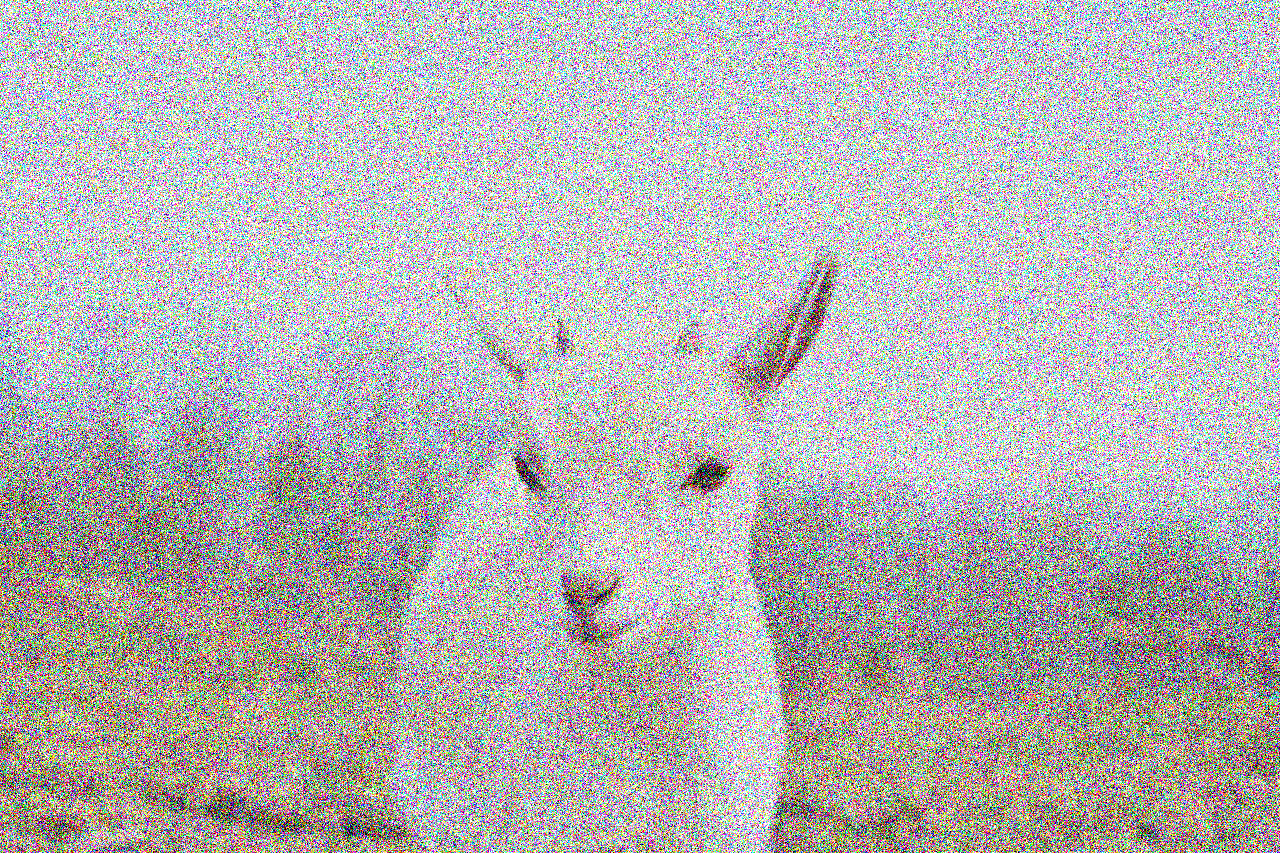

In [39]:
import numpy as np
from IPython.display import display

# ノイズを生成する関数
def add_noise_temp(image, noise_factor=0.5):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0., 1.)
    return noisy_image

# 画像にノイズを追加
noisy_image = add_noise_temp(img_array)

#画像を表示
image = Image.fromarray((noisy_image * 255).astype(np.uint8))
display(image)

In [40]:
#input_dataを作成
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch

# MNISTデータセットをダウンロード
dataset = MNIST(root='./data', download=True, train=True, transform=transforms.ToTensor())

# データセットから一つの画像を取得
image, label = dataset[0]


# 画像を平坦化
input_data = image.view(-1, 28*28).float()

#add_noiseをtensorに
def add_noise(image, noise_factor=0.5):
    # PyTorchを使用してノイズを生成
    noise = torch.randn_like(image) * noise_factor
    # ノイズを画像に追加
    noisy_image = image + noise
    # 結果を0と1の間にクリップ
    noisy_image = torch.clamp(noisy_image, 0., 1.)
    return noisy_image


In [41]:
import torch
import torch.nn as nn


# デノイジングオートエンコーダモデルの定義
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # latent space
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() # to get the pixel values in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# モデルのインスタンス化
model = DenoisingAutoencoder()

# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 入力データにノイズを加える
noisy_data = add_noise(input_data) # Assume add_noise function and input_data are defined

# デノイジングの実行
model.train()
for epoch in range(100): # Assume we train for 100 epochs
    optimizer.zero_grad()
    outputs = model(noisy_data)
    loss = criterion(outputs, input_data) # We want our output to be as close to the original clean input_data as possible
    loss.backward()
    optimizer.step()

# ノイズ除去後のデータを取得
model.eval()
denoised_data = model(noisy_data)

In [42]:
# 学習の設定
epochs = 100
for epoch in range(epochs):
    model.train() # モデルを訓練モードに設定

    # バッチごとの訓練
    for batch in dataloader: # dataloaderは訓練データをバッチに分割して提供します
        # データをGPUに送る
        batch = batch.to(device) # deviceはCPUまたはGPUを指します

        # モデルの出力を計算
        outputs = model(batch)

        # 損失を計算
        loss = criterion(outputs, batch) # criterionは損失関数（例えば、nn.MSELoss()）を指します

        # 勾配をゼロに初期化
        optimizer.zero_grad()

        # 逆伝播を行い、勾配を計算
        loss.backward()

        # パラメータを更新
        optimizer.step()

# 学習結果の保存（必要に応じて）
torch.save(model.state_dict(), "model.pth")

NameError: name 'dataloader' is not defined